### MONTHLY BUDGET CALCULATION

This script takes as input:
- the total monthly precipitation and potential evapotranspiration over the catchment area (clipped from the ERA5 dataset reanalysis)
- the total monthly discharge measured in river catchments

the goal is to compare the two values and check quality of the measured catchments.

In [1]:
#import the needed libraries
from matplotlib import pyplot as plot
import os
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import os
from scipy import stats
import seaborn as sns
os.chdir('C:/Users/mmazzolini/OneDrive - Scientific Network South Tyrol/Documents/conda/monthly_data_discharge')
root = tk.Tk()
root.withdraw()

''

#### SELECT THE NETCDF DATA

In [2]:
evap_path = filedialog.askopenfilename(initialdir='C:/Users/mmazzolini/OneDrive - Scientific Network South Tyrol/Documents/conda/monthly_data_evap',
                                        title='select the ERA5 data')
precip_path = evap_path.replace('evap','precip',1) 
print(evap_path)

C:/Users/mmazzolini/OneDrive - Scientific Network South Tyrol/Documents/conda/monthly_data_evap/ADIGE_BRONZOLO.csv


In [3]:
print(evap_path)

C:/Users/mmazzolini/OneDrive - Scientific Network South Tyrol/Documents/conda/monthly_data_evap/ADIGE_BRONZOLO.csv


#### SELECT THE DISCHARGE DATA

In [4]:
disch_path = filedialog.askopenfilename(initialdir='C:/Users/mmazzolini/OneDrive - Scientific Network South Tyrol/Documents/conda/monthly_data_discharge',
                                        title='select the discharge data')
print(disch_path)

C:/Users/mmazzolini/OneDrive - Scientific Network South Tyrol/Documents/conda/monthly_data_discharge/Etsch - Branzoll_85550PG_8555QQ0010A_19761231000000_20210721000000.csv


#read the csv files
disch_df = pd.read_csv(disch_path,
                 header=0,
                 index_col=0)

precip_df = pd.read_csv(precip_path,
                 header=0,
                 index_col=0)

evap_df = pd.read_csv(evap_path,
                 header=0,
                 index_col=0)

#make the indices a datetime object
disch_df.index  = pd.to_datetime(disch_df.index, format='%Y-%m')
precip_df.index = pd.to_datetime(precip_df.index, format='%Y-%m')
evap_df.index   = pd.to_datetime(evap_df.index, format='%Y-%m')

meteo_df = pd.merge(evap_df.assign(grouper=evap_df.index.to_period('M')),
               precip_df.assign(grouper=precip_df.index.to_period('M')),
               how='inner', on='grouper')

#merge the two datasets
df = pd.merge(disch_df.assign(grouper=disch_df.index.to_period('M')),
               meteo_df.assign(grouper=precip_df.index.to_period('M')),
               how='inner', on='grouper')

In [6]:
#read the csv files
disch_df = pd.read_csv(disch_path,
                 header=0,
                 index_col=0)

precip_df = pd.read_csv(precip_path,
                 header=0,
                 index_col=0)

evap_df = pd.read_csv(evap_path,
                 header=0,
                 index_col=0)

#make the indices a datetime object
disch_df.index  = pd.to_datetime(disch_df.index, format='%Y-%m')
precip_df.index = pd.to_datetime(precip_df.index, format='%Y-%m')
evap_df.index   = pd.to_datetime(evap_df.index, format='%Y-%m')


meteo_df = pd.merge(evap_df.assign(grouper=evap_df.index.to_period('M')),
               precip_df.assign(grouper=precip_df.index.to_period('M')),
               how='inner', on='grouper')
#disch_df.rename(columns={'Q':'total_discharge m_3'},inplace=True)
#merge the two datasets
df = pd.merge(disch_df.assign(grouper=disch_df.index.to_period('M')),
               meteo_df.assign(grouper=precip_df.index.to_period('M')),
               how='inner', on='grouper')

df.rename(columns={'grouper':'month','total_discharge m_3':'total_discharge_m_3'}, inplace=True)
df.index = df.month
df.drop(columns='month',inplace = True)


#df['total_outflow_m3']=df['total_discharge m_3']+df['total_month_evap_m3']
df['precipitation-evapotranspiration_m_3'] =df['total_month_precip_m3']-df['total_month_evap_m3']

shifted_discharge = df['total_discharge_m_3'].shift(periods=1,freq='1M')
df['shifted_discharge'] = shifted_discharge

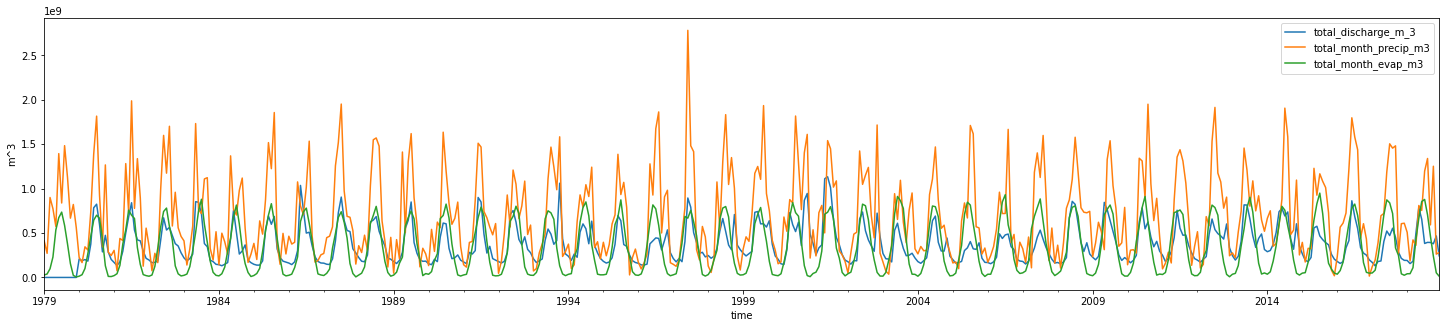

In [7]:
#PLOT THE RESULTS
ax=df.plot.line(y=['total_discharge_m_3','total_month_precip_m3','total_month_evap_m3'],
                      #title=name+' BASIN',
                      figsize=(25,5),
                      ylabel='m^3',
                      xlabel='time')


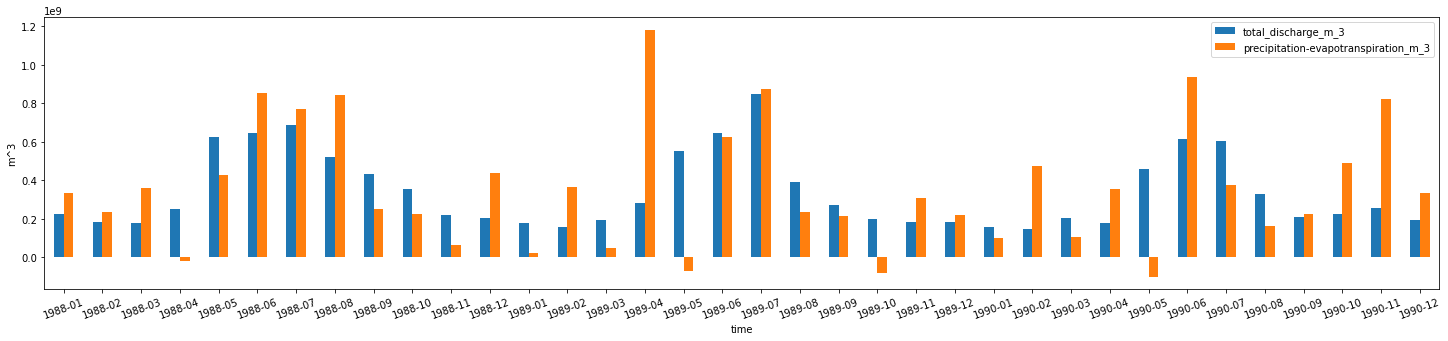

In [8]:
#PLOT THE RESULTS
ax = df[108:144].plot.bar(y=['total_discharge_m_3','precipitation-evapotranspiration_m_3'],
                      #title=name+' BASIN',
                      figsize=(25,5),
                      ylabel='m^3',
                      xlabel='time',
                      rot=20)
                    

r value (linear correlation) is 0.383
p value (no correlation probability) is  2.9869822352392952e-18


(-56669487.0, 1190059227.0, -568013167.1112304, 2240970981.53987)

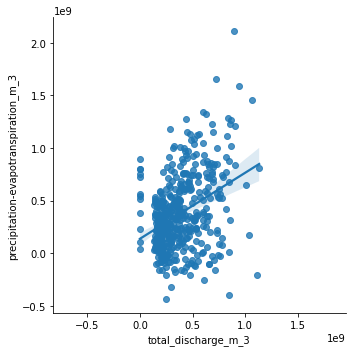

In [9]:
test=stats.pearsonr(df['total_discharge_m_3'], df['precipitation-evapotranspiration_m_3'])

print('r value (linear correlation) is %.3f' % test[0])
print('p value (no correlation probability) is ',test[1])

sns.lmplot(x='total_discharge_m_3',
                y='precipitation-evapotranspiration_m_3',
                data=df,
                )
plot.axis('equal')

r value (linear correlation) is 0.196
p value (no correlation probability) is  1.60523078778232e-05


(-56669487.0, 1190059227.0, -568013167.1112304, 2240970981.53987)

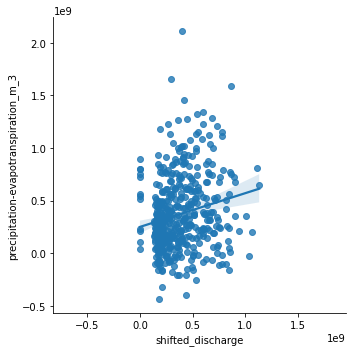

In [10]:
test2=stats.pearsonr(df['shifted_discharge'].iloc[1:], df['precipitation-evapotranspiration_m_3'].iloc[1:])

print('r value (linear correlation) is %.3f' % test2[0])
print('p value (no correlation probability) is ',test2[1])

sns.lmplot(x='shifted_discharge',
                y='precipitation-evapotranspiration_m_3',
                data=df,
                )
plot.axis('equal')

# yearly budget
df_year = df.groupby(df.index.year).sum()
#PLOT THE RESULTS
ax = df_year.plot.bar(y=['total_discharge_m_3','precipitation-evapotranspiration_m_3'],
                      #title=name+' BASIN',
                      figsize=(25,5),
                      ylabel='m^3',
                      xlabel='time',
                      rot=20)

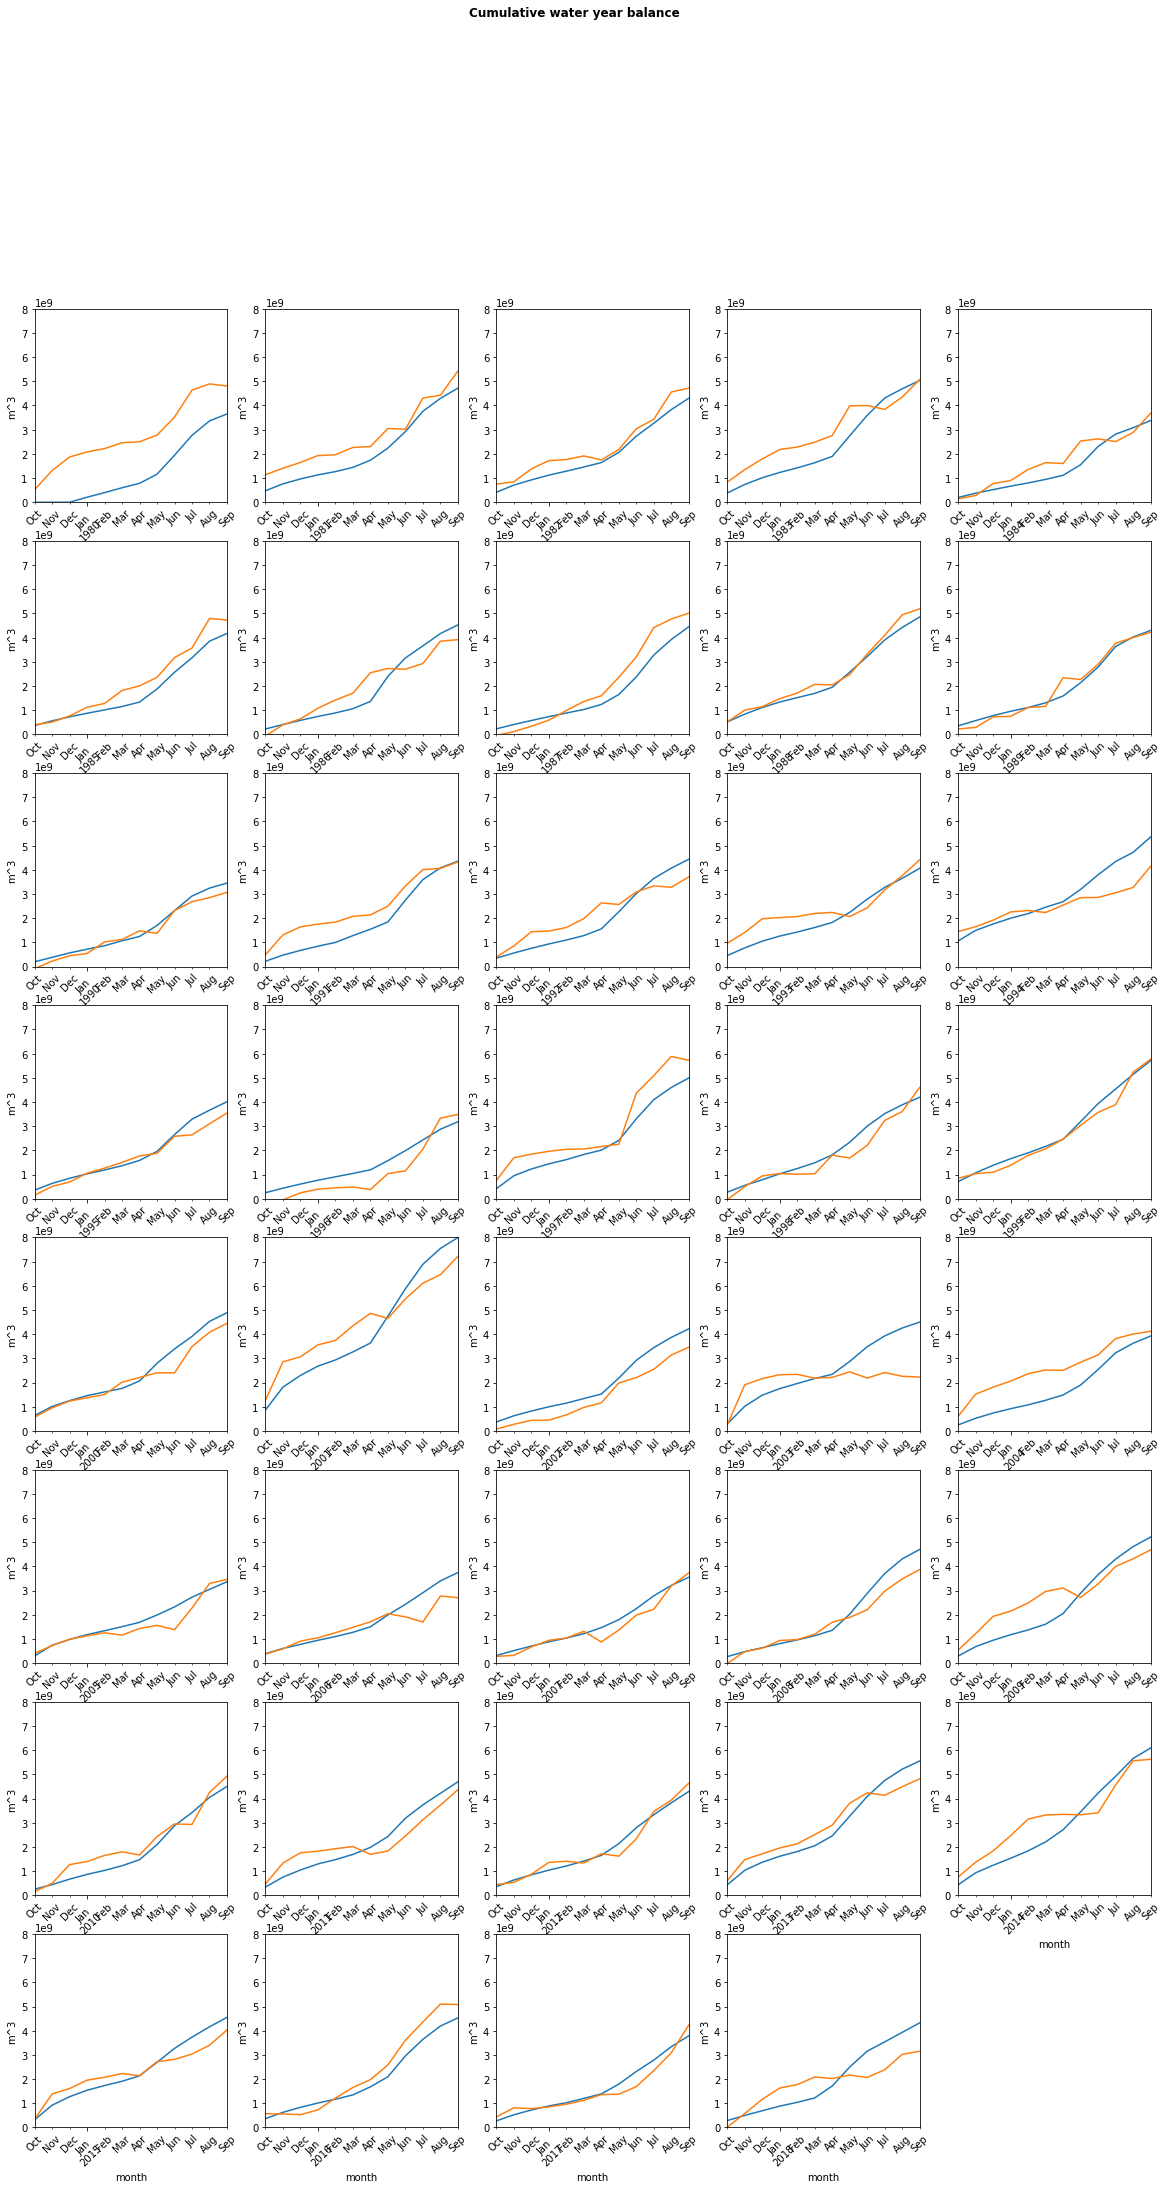

In [19]:
df['hydro_year']= df.index.year

df.loc[df.index.month>9,'hydro_year'] = df[df.index.month>9].index.year+1

df_cum = df.groupby(df.hydro_year).cumsum()
df_cum['hydro_year']= df_cum.index.year
df_cum.loc[df_cum.index.month>9,'hydro_year'] = df_cum[df_cum.index.month>9].index.year+1


start_year = df_cum['hydro_year'][0]
ylimit= 0.8*(10**10)

fig=plot.figure(figsize=(20,42))
fig.suptitle('Cumulative water year balance',fontweight="bold")
j=1
for i in df_cum['hydro_year'].unique():
    if df_cum[df_cum['hydro_year']==i].iloc[-1].number >=365:
        plot.subplot(10,5,j)

        df_cum[df_cum['hydro_year']==i].plot.line(y=['total_discharge_m_3','precipitation-evapotranspiration_m_3'],
                                                  legend=None,
                                                  #title='Hydrological year '+ str(i),
                                                  
                                                  ylim=(0,ylimit),
                                                  
                                                  ylabel='m^3',
                                                  rot=45,
                                                  ax=plot.gca(),
                                                 )
        

        j=j+1


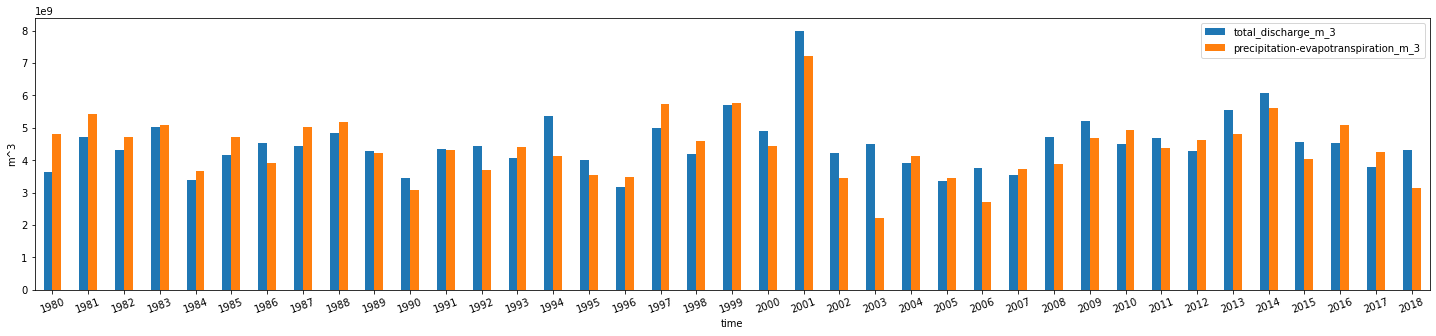

In [13]:
df_wyear = df.groupby(df.hydro_year).sum()
df_wyear.drop(df_wyear[df_wyear.number < 365].index,inplace=True)

ax = df_wyear.plot.bar(y=['total_discharge_m_3','precipitation-evapotranspiration_m_3'],
                      #title=name+' BASIN',
                      figsize=(25,5),
                      ylabel='m^3',
                      xlabel='time',
                      rot=20)

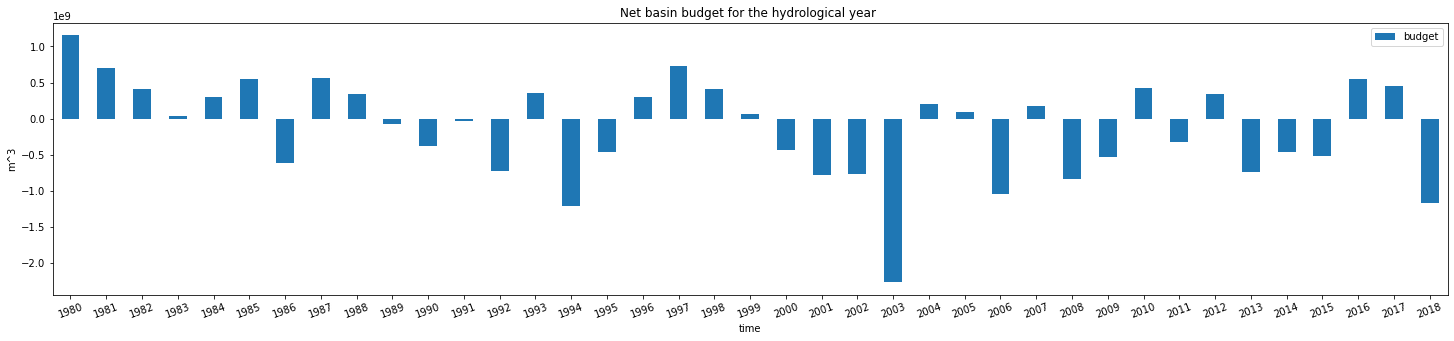

In [14]:
df_wyear['budget']=df_wyear['precipitation-evapotranspiration_m_3']  -  df_wyear['total_discharge_m_3']
ax = df_wyear.plot.bar(y='budget',
                      #title=name+' BASIN',
                      figsize=(25,5),
                      ylabel='m^3',
                      xlabel='time',
                      rot=20,
                      title='Net basin budget for the hydrological year ')